# 7.3 Using built-in training and evaluation loops
- The standard way to build machine learning model is to compile(), fit(), evaluate(), predict()
- There are more way to customize the process:
    - Provide your own custom metrics.
    - Write your own calll backs.
    - Monitor and visualize your results.

In [1]:
# import libraries
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

## A. ML General Workflow: compile(), fit(), evaluate(), predict()

In [2]:
def get_mnist_model():
    # create a model using Functional API
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features) # multi-class classification, single output
    model = keras.Model(inputs, outputs)
    return model

In [3]:
# load dataset
(images, labels), (test_images, test_labels) = mnist.load_data()

# flatten images
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255

# get the training and validation set
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# create a model
model = get_mnist_model()

# compile the model by specifying its optimizer, loss functionn, and metrics
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# train and validate the model
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))

# test model
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

2023-02-17 20:11:53.799281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-17 20:11:53.799346: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2951 - accuracy: 0.9126 - val_loss: 0.1452 - val_accuracy: 0.9580
Epoch 2/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1661 - accuracy: 0.9529 - val_loss: 0.1180 - val_accuracy: 0.9678
Epoch 3/3
313/313 [==============================] - 1s 2ms/step


## B. Write your own metrics
- Keras has Metric class, however, the variables aren't updated via backpropagation, so we need to write the state-update logic.

### Implement a custom metric by subclassing the Metric class

In [5]:
class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        """Constructor"""
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32"
        )
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        """Implement state updates"""
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
        
    def result(self):
        """Return the values of the metrics"""
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    def reset_state(self):
        """Reset without reinitialize"""
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [6]:
# build a model
model = get_mnist_model()

# initilize optimizer, loss, metrics
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])

# train model
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))

# test model
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2971 - accuracy: 0.9124 - rmse: 7.1814 - val_loss: 0.1519 - val_accuracy: 0.9562 - val_rmse: 7.3549
Epoch 2/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1671 - accuracy: 0.9528 - rmse: 7.3544 - val_loss: 0.1290 - val_accuracy: 0.9644 - val_rmse: 7.4005
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1122 - accuracy: 0.9704 - rmse: 7.4333


## C. Using callbacks
- Training your model with `fit()` can take a lot of resource, thus `callback` object is callled by the model at various points during training. The object has access to all the available data about the state of the model and its performance. 
- It can have some actions:
    - interrupt training.
    - save a model.
    - load a different weight set.
    - alter the state of the model
- Some examples of using callbacks:
    - Model checkpointing: Saving the current state of the model at different points during training.
    - Early stopping: Interrupt training when the validation loss is no longer improving.
    - Dynamically adjusting the value of certain parameter during training: such as the learning rate of the optimizer.
    - Logging training and validationn metrics during training, or visualizing the representations learned by the model as they're updated.
- Some of the function calls;
```python
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
```

### The EarlyStopping & ModelCheckpoint Callbacks
- When you are training, there are many things you can't predict such as number of epochs. Previously, we have to retrain from scratch, which is wasteful of resource. A better way is to stop training when you measure that the validation loss is no longer improving.
- Let's write the code using callbacks argument in the `fit()` method.

In [7]:
# callbackks are passed to the model via fit() which takes a list of call backs
callback_list = [
    # interrupts training when improvement stops
    keras.callbacks.EarlyStopping( 
        monitor="val_accuracy", # monitors the model's validation accuracy
        patience=2,             # innterrupt training when accuracy has stopped improving for 2 epochs
    ),
    
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras", # save the current weights after every epochs
        monitor="val_loss",  # don't overwrite the model file unless val_loss has improoved which allow you to keep the best model seen during training
        save_best_only=True,
    )
]

In [8]:
# build model
model = get_mnist_model()

# compile the model
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# train and validate the model
model.fit(train_images, train_labels, epochs=10, callbacks=callback_list, validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2940 - accuracy: 0.9129 - val_loss: 0.1575 - val_accuracy: 0.9552
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1648 - accuracy: 0.9537 - val_loss: 0.1194 - val_accuracy: 0.9683
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1415 - accuracy: 0.9624 - val_loss: 0.1152 - val_accuracy: 0.9704
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1265 - accuracy: 0.9674 - val_loss: 0.1062 - val_accuracy: 0.9744
Epoch 5/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1165 - accuracy: 0.9708 - val_loss: 0.1064 - val_accuracy: 0.9759
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1091 - accuracy: 0.9728 - val_loss: 0.1054 - val_accuracy: 0.9759
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1086 - accuracy: 0.9743 - val_loss: 0.1061 - val_accuracy:

In [9]:
# # you can always save the model manually after training
# model.save("my_checkpoint_path")

# # load the model
# model = keras.models.load_model("my_checkpoint_path.keras")

### Create a custom callback by subclassing the Callback class

In [10]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        """Called at the start of training"""
        self.per_batch_losses = []
        
    def on_batch_end(self, batch, logs):
        """Called right after processing each batch"""
        self.per_batch_losses.append(logs.get("loss"))
        
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
        label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2917 - accuracy: 0.9144 - val_loss: 0.1496 - val_accuracy: 0.9566
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1620 - accuracy: 0.9542 - val_loss: 0.1314 - val_accuracy: 0.9654
Epoch 3/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1390 - accuracy: 0.9629 - val_loss: 0.1093 - val_accuracy: 0.9720
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1225 - accuracy: 0.9680 - val_loss: 0.1131 - val_accuracy: 0.9728
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1173 - accuracy: 0.9702 - val_loss: 0.1129 - val_accuracy: 0.9748
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1115 - accuracy: 0.9727 - val_loss: 0.1127 - val_accuracy: 0.9739
Epoch 7/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1066 - accuracy: 0.9748 - val_loss: 0.1032 - val_accuracy

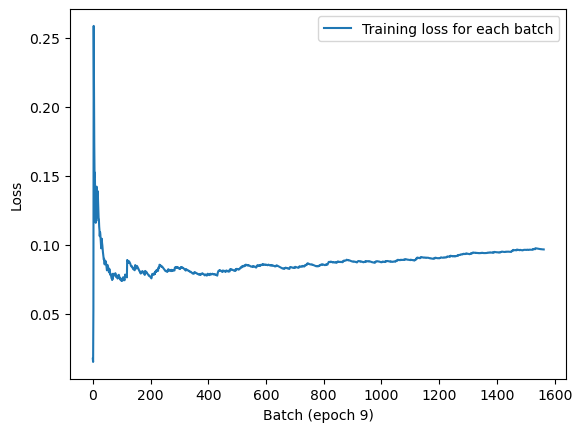

In [11]:
# build the model
model = get_mnist_model()

# init the model optimizer, loss, metrics
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# train and validate the model
model.fit(train_images, train_labels, epochs=10, callbacks=[LossHistory()], validation_data=(val_images, val_labels))

### Monitoring & Visualization with TensorBoard

In [12]:
# build model
model = get_mnist_model()

# init the model optimizer, loss, metrics
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)

# train and validate the model
model.fit(train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2925 - accuracy: 0.9137 - val_loss: 0.1487 - val_accuracy: 0.9579
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1643 - accuracy: 0.9536 - val_loss: 0.1193 - val_accuracy: 0.9671
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1362 - accuracy: 0.9634 - val_loss: 0.1137 - val_accuracy: 0.9720
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1241 - accuracy: 0.9681 - val_loss: 0.1130 - val_accuracy: 0.9714
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1172 - accuracy: 0.9701 - val_loss: 0.1123 - val_accuracy: 0.9741
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1126 - accuracy: 0.9727 - val_loss: 0.1085 - val_accuracy: 0.9761
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1088 - accuracy: 0.9751 - val_loss: 0.1095 - val_accuracy:

In [13]:
!pip install tensorboard

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.10.1 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.61.0 which is incompatible.
tfx-bsl 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-transform 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-serving-api 2.10.0 requires tensorflow<3,>=2.10.0, but you have tensorflow 2.9.2 which is incompatible.
ortools 9.5.2237 requires protobuf>=4.21.5, but you

In [14]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

## D. Write your own training & evaluation loop
- The function fit() will not work for task with no explicit targets are presented such as gneerative learning, self-supervised learning, or reinforcement learning.

### A step-by-step training loop - fit() with many features

In [15]:
model = get_mnist_model()

# loss function
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# optimizer
optimizer = keras.optimizers.RMSprop()

# list of metrics to monitor
metrics = [keras.metrics.SparseCategoricalAccuracy()]

# list of metrics to track the loss average
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    # keep track of metrics
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()
        
    # keep track of loss average
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    
    # return the current values of the metrics and loss
    return logs

def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

In [16]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3

for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9124
...loss: 0.2924
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9535
...loss: 0.1649
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9625
...loss: 0.1429


### A step-by-step evaluation loop - evaluate() with many features

In [17]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs
    
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
    
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9683
...val_loss: 0.1295


### Make it fast with tf.function
- Note that the customed fit() and evaluate() function is slower despeite the same logic. This is because TF code is executed line by line. It's more performant to compile your TF code into a computation graph that can be globally optimized in a way that code interpreted line by line can't. We can do this by using a decorator.

In [18]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs
    
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
    
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9683
...val_loss: 0.1295


### Leveraging fit() with a custom training loop
- When writing your customed training and evaluation loop from scratch, you will have to write a lot of code. What if you want to leverage the power of built-in Keras trainning logic? There is a way: you can provide a custom training step function and let the framework do the rest.
- To do this, you will have to overrite the train_step() of the Model class.
- Steps:
    - Create a new class of subclasses keras.Model
    - Overrite the method train_step(self, data.
    - Implement a metrics property that tracks the model's Metric instances, this enables the model to automatically call reset_state() on the model's metricsat the start of each epoch and at the start of each epoch and at the start of a call to evalute(), so you don't have to do it by hand.
   

In [19]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# metric object to track the average of per-batch losses during training and evaluation.
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        """Override the train_step method"""
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        # update the loss tracker metrics that tracks the average of the loss
        loss_tracker.update_state(loss)
        
        # return the average loss 
        return {"loss": loss_tracker.result()}
    
    @property
    def metrics(self):
        return [loss_tracker]

In [20]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2929
Epoch 2/3
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1667
Epoch 3/3
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1378


**Note**: What about configure the metrics and the loss via compile()

In [21]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [22]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)

model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.9130
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9532
Epoch 3/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1391 - sparse_categorical_accuracy: 0.9636
